In [557]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [558]:
FLT = pd.read_excel('Jianing_FLT.xlsx')
print(FLT)


                     Date  FLT GEM Debiet influent even kant  \
0     2020-12-31 15:00:00                        2965.654955   
1     2020-12-31 16:00:00                        2959.352060   
2     2020-12-31 17:00:00                        3009.247133   
3     2020-12-31 18:00:00                        3097.382712   
4     2020-12-31 19:00:00                        3014.303905   
...                   ...                                ...   
26246 2023-12-30 05:00:00                        2514.307238   
26247 2023-12-30 06:00:00                        2504.993905   
26248 2023-12-30 07:00:00                        2508.532285   
26249 2023-12-30 08:00:00                        2508.574482   
26250 2023-12-30 09:00:00                        2523.169808   

       FLT GEM Debiet influent oneven kant  FLT GEM Turb influent oneven  \
0                              3483.320557                      0.430411   
1                              3496.040518                      0.522836   
2  

In [559]:
FLT['FLT GEM Turb influent oneven'].interpolate(method='linear',inplace=True)

In [560]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(FLT['Date'], FLT['FLT GEM Turb influent oneven'])
ax.set_xlabel('Timesteps', fontsize=20)
ax.set_ylabel('Turbidity', fontsize=20)
ax.set_title('Turbidity oneven', fontsize=20)

fig.autofmt_xdate() 
plt.legend()
plt.tight_layout()

plt.savefig('figures/baseline models/random walk model_Turbidity oneven.png', dpi=300)

### Testing for stationarity

In [561]:
Data_Turbidity = FLT['FLT GEM Turb influent oneven']
ADF_result = adfuller(Data_Turbidity)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.780097508622358
p-value: 0.0031176350310033745


In [562]:
plot_acf(Data_Turbidity, lags=20);

plt.tight_layout()
plt.savefig('figures/CH03_F09_peixeiro.png', dpi=300)



In [563]:
diff_Data_Turbidity = np.diff(Data_Turbidity, n=1)

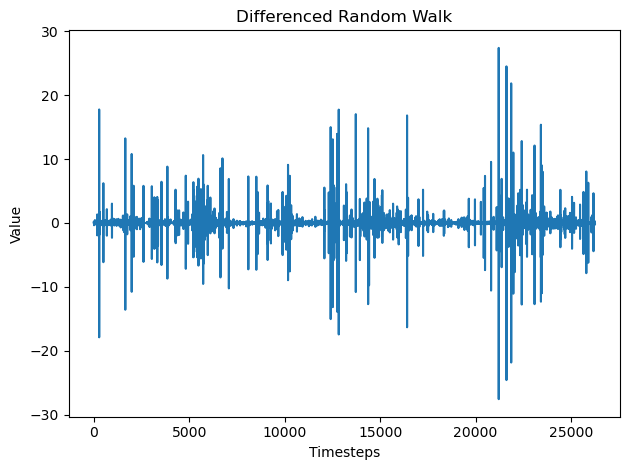

In [576]:
plt.plot(diff_Data_Turbidity)
plt.title('Differenced Random Walk')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.tight_layout()

plt.savefig('figures/CH03_F10_peixeiro.png', dpi=300)
plt.show()

In [588]:
ADF_result = adfuller(diff_Data_Turbidity)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -33.030296057704874
p-value: 0.0


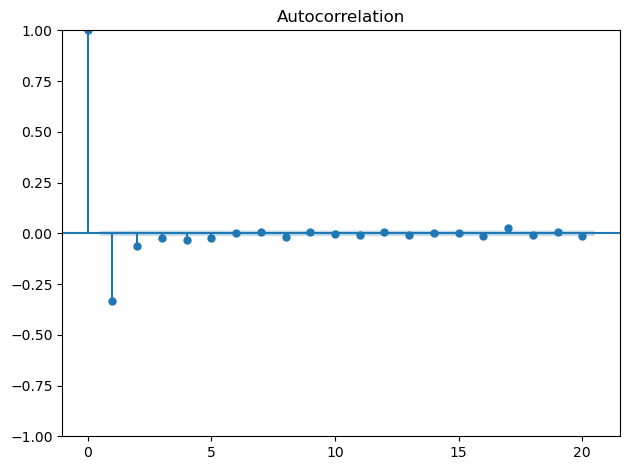

In [593]:
plot_acf(diff_Data_Turbidity, lags=20);

plt.tight_layout()

plt.savefig('figures/CH03_F11_peixeiro.png', dpi=300)
plt.show()

## Forecasting a random walk
### Forecasting on a long horizon

In [579]:
Data = pd.DataFrame({'value': Data_Turbidity})

train = Data[:23626]
test = Data[23626:]

print(len(train))
print(len(test))


23626
2625


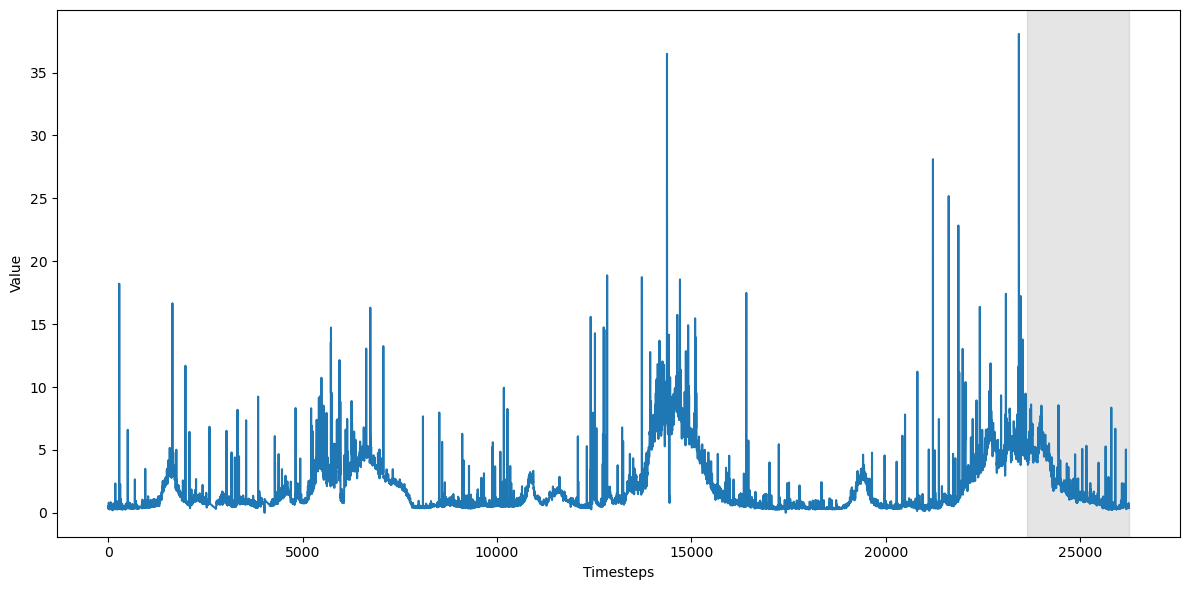

In [580]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(Data)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.axvspan(23626, 26251, color='#808080', alpha=0.2)

plt.tight_layout()
plt.savefig('figures/CH03_F14_peixeiro.png', dpi=300)
plt.show()

In [581]:
mean = np.mean(train.value)

test.loc[:, 'pred_mean'] = mean

test.head()

,value,pred_mean
23626,4.165461,1.883015
23627,4.117454,1.883015
23628,4.146334,1.883015
23629,4.441603,1.883015
23630,4.880803,1.883015


In [582]:
last_value = train.iloc[-1].value

test.loc[:, 'pred_last'] = last_value

test.head()

,value,pred_mean,pred_last
23626,4.165461,1.883015,4.454618
23627,4.117454,1.883015,4.454618
23628,4.146334,1.883015,4.454618
23629,4.441603,1.883015,4.454618
23630,4.880803,1.883015,4.454618


In [583]:
last_value = 4.454618
initial_value = 0.430410875

deltaX = 23625 - 0
deltaY = last_value - initial_value

drift = deltaY / deltaX
print(drift)


0.00017033680952380952


In [584]:

x_vals = np.arange(23626, 26251, 1)

pred_drift = drift * x_vals + initial_value

test.loc[:, 'pred_drift'] = pred_drift

test.head()

,value,pred_mean,pred_last,pred_drift
23626,4.165461,1.883015,4.454618,4.454788
23627,4.117454,1.883015,4.454618,4.454959
23628,4.146334,1.883015,4.454618,4.455129
23629,4.441603,1.883015,4.454618,4.455299
23630,4.880803,1.883015,4.454618,4.455470


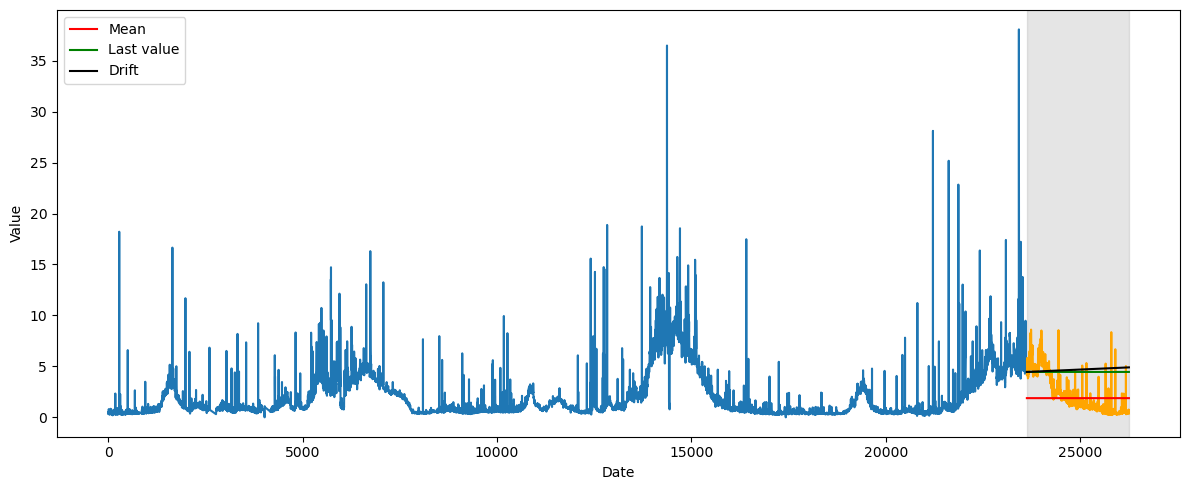

In [585]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(train.value)
ax.plot(test['value'], 'orange')
ax.plot(test['pred_mean'], 'red', label='Mean')
ax.plot(test['pred_last'], 'green', label='Last value')
ax.plot(test['pred_drift'], 'black', label='Drift')

ax.axvspan(23626, 26251, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.tight_layout()
plt.savefig('figures/CH03_F15_peixeiro.png', dpi=300)
plt.show()

In [586]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

3.5264869519703548 8.833775328582751 10.352065145345689


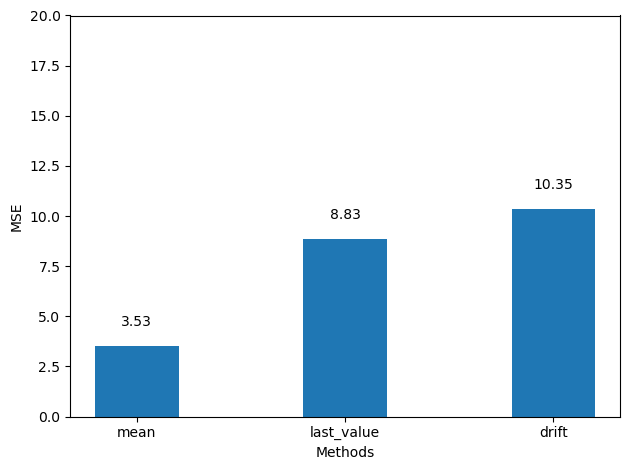

In [587]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'drift']
y = [mse_mean, mse_last, mse_drift]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 20)

for index, value in enumerate(y):
    plt.text(x=index, y=value+1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH03_F16_peixeiro.png', dpi=300)
plt.show()